# GenVeg Main Script
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [32]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file

### Define time controls

In [33]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=365

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [34]:
VegInputFile = 'GenVeg_Example_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [35]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize'])
#VegParams(processes=['plantsize','dispersal','colonization','storage','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)


ValueError: File path is not valid

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [ ]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((5, 5), 2.0, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

meantemp=[0.444444445,0.305555556,0.222222223,0.138888889,0.027777777,-0.083333334,-0.138888889,-0.25,-0.305555556,-0.416666667,-0.472222223,-0.527777778,-0.583333334,-0.638888889,-0.694444445,-0.75,-0.777777778,-0.805555556,-0.861111111,-0.861111111,-0.861111111,-0.888888889,-0.916666667,-0.916666667,-0.888888889,-0.861111111,-0.861111111,-0.833333333,-0.805555556,-0.777777778,-0.722222222,-0.666666667,-0.638888889,-0.583333333,-0.527777778,-0.472222222,-0.388888889,-0.333333334,-0.25,-0.166666667,-0.083333334,-0.027777777,0.083333334,0.166666667,0.277777778,0.361111111,0.472222222,0.583333333,0.666666667,0.777777778,0.888888889,1,1.083333334,1.194444445,1.305555556,1.416666667,1.527777778,1.611111111,1.694444445,1.805555556,1.916666667,2.027777778,2.138888889,2.25,2.333333334,2.444444445,2.555555556,2.638888889,2.75,2.861111111,2.944444445,3.055555556,3.166666667,3.25,3.361111112,3.444444445,3.555555556,3.694444445,3.777777778,3.888888889,4,4.083333334,4.222222223,4.333333334,4.444444445,4.583333334,4.694444445,4.833333333,4.944444444,5.083333334,5.222222223,5.333333334,5.5,5.638888889,5.777777778,5.916666667,6.083333334,6.222222222,6.38888889,6.555555554,6.722222222,6.88888889,7.055555554,7.222222222,7.38888889,7.555555554,7.722222222,7.88888889,8.083333334,8.250000002,8.444444443,8.638888891,8.805555555,8.972222223,9.166666666,9.333333335,9.527777778,9.694444446,9.888888887,10.08333334,10.25,10.44444444,10.61111111,10.77777778,10.97222222,11.13888889,11.27777778,11.47222222,11.63888889,11.80555556,11.97222222,12.16666667,12.33333333,12.47222222,12.63888889,12.80555555,13,13.16666667,13.33333333,13.47222222,13.63888889,13.80555556,13.97222222,14.13888889,14.33333334,14.47222222,14.63888889,14.80555556,14.97222222,15.16666667,15.33333334,15.5,15.66666667,15.86111112,16.02777778,16.22222222,16.38888889,16.58333334,16.75,16.91666667,17.13888889,17.30555556,17.47222223,17.66666667,17.86111112,18.02777778,18.22222223,18.38888889,18.58333334,18.75,18.91666667,19.08333334,19.27777778,19.41666667,19.58333334,19.75,19.91666667,20.08333334,20.19444445,20.36111112,20.47222223,20.63888889,20.75,20.86111112,20.97222223,21.08333334,21.19444445,21.30555556,21.38888889,21.47222223,21.55555556,21.61111111,21.69444445,21.75,21.80555556,21.83333334,21.88888889,21.94444445,21.94444445,22,22,22,22.02777778,22.02777778,22.02777778,22.02777778,22,22,21.97222222,21.97222222,21.91666667,21.91666667,21.86111111,21.86111111,21.80555556,21.75,21.72222222,21.66666667,21.61111111,21.58333334,21.52777778,21.47222223,21.41666667,21.36111112,21.30555556,21.25,21.16666667,21.11111111,21.05555556,20.97222222,20.91666667,20.83333333,20.75,20.69444445,20.58333334,20.5,20.44444445,20.33333334,20.25,20.13888889,20.05555556,19.94444444,19.80555556,19.69444445,19.58333334,19.44444445,19.33333334,19.19444445,19.08333334,18.91666667,18.80555556,18.63888889,18.5,18.33333333,18.19444445,18.02777778,17.86111111,17.69444445,17.52777778,17.36111111,17.19444445,16.97222223,16.80555556,16.61111112,16.44444445,16.25,16.08333334,15.88888889,15.66666667,15.47222222,15.30555556,15.11111112,14.91666667,14.72222222,14.55555556,14.36111111,14.13888889,13.94444444,13.77777778,13.58333333,13.41666667,13.22222222,13.05555555,12.88888889,12.72222222,12.52777778,12.36111111,12.19444444,12.02777778,11.88888889,11.72222222,11.55555556,11.38888889,11.25,11.08333333,10.91666667,10.77777778,10.63888889,10.5,10.33333334,10.19444444,10.05555556,9.916666666,9.750000002,9.611111112,9.472222221,9.361111111,9.194444442,9.055555557,8.916666666,8.777777776,8.611111112,8.472222222,8.333333331,8.194444446,8.027777777,7.888888887,7.750000001,7.583333333,7.444444442,7.277777779,7.138888889,6.97222222,6.805555555,6.638888891,6.500000001,6.333333332,6.166666669,6.027777778,5.861111111,5.694444445,5.527777778,5.361111111,5.194444445,5.027777778,4.861111111,4.694444445,4.527777778,4.361111111,4.194444445,4.027777778,3.861111111,3.722222222,3.555555556,3.388888889,3.222222222,3.083333334,2.916666667,2.75,2.611111112,2.444444445,2.305555556,2.138888889,2,1.833333333,1.722222222,1.555555556,1.416666667,1.305555556,1.166666667,1.027777778,0.888888889,0.777777778,0.666666667,0.555555556
]
dailyTotGlobRad=[22.3, 26.8, 32.2, 37.1, 40.0, 40.9, 40.4, 38.2, 33.9, 28.5, 23.3, 21.0]
                
#Initialize with a random mean air temperture 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__net_flux', dailyTotGlobRad[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')


Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Corn, 1/2 by wheat, at single and double planting densities, respectively

In [ ]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
plant_species_init=['Corn','Wheat']
plant_list_1=['Corn','null','null','null']
plant_list_2=['null','null','Wheat','null']
plant_list_3=['Corn','Corn','null','null']
plant_list_4=['null','null','Wheat','Wheat']
plant_lists=[plant_list_1,plant_list_2,plant_list_3, plant_list_4]
plants_on_grid=[]
length_field_part=pg.number_of_cells/4
for plant_list in plant_lists:
    for i in range(int(length_field_part)):
        #if plants_on_grid.isempty
        plants_on_grid.append(plant_list)

_ = pg.add_field('vegetation__plant_species',plants_on_grid, at='cell', clobber=True)

#occupied_ids=np.where(pg.at_cell['vegetation__plant_species']=='BTS')

pidval=0
plants=pd.DataFrame(columns=['pid','species','cell_index'])
for cell in range(pg.number_of_cells):
    cell_index=cell
    cell_plants=pg['cell']['vegetation__plant_species'][cell]
    for plant in cell_plants:
        species=plant
        newrow=[pidval,species,cell_index]
        plants.loc[pidval]=newrow
        pidval += 1

pid=plants.pid.loc[plants['species']=='BTS'].to_numpy(int)
total_biomass=np.random.rand(pid.shape[0])
total_biomass2=np.random.rand(6)

species_set=np.vstack((pid,total_biomass))
species_set2=np.vstack((total_biomass2,total_biomass2))
species_set=np.transpose(species_set)
species_set2=np.transpose(species_set2)
biomass=np.concatenate((species_set,species_set2), axis=0)
print(biomass)
biomass=np.transpose(biomass)
print(biomass)

### Plot grid with plant distribution and initial biomass

Use RasterModelGrid plot functions to visualize initial model grid

#### Vegetation type 
- 0=Bare
- 1=Annual
- 2=Herbaceous Perennial 
- 3=Woody Perennial

### Define model time variables
Determine basic model timestep and counter for model loop

sim_end = date(sim_start_date.year+tot_sim_len_y,sim_start_date.month,sim_start_date.day)
dt = min([veg_time_step_d,env_time_step_d])
#data['dt']=dt
day_freq = str(dt)+'D'
date_counter = pd.date_range(start=sim_start_date,end=sim_end,freq=day_freq).strftime('%Y-%m-%d').tolist()
step_counter=range(len(date_counter))
model_counter=tuple(zip(step_counter,date_counter))

Initialize crops PlantGrowth class with veg_params from Excel file

In [ ]:
croprun=GenVeg(pg,dt,sim_start_date,vegparams)




d:\python\landlab\landlab\plot\imshow.py:288: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(alpha=0.0)
d:\python\landlab\landlab\plot\imshow.py:328: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


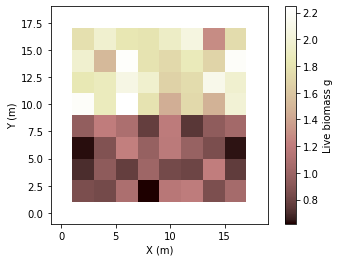

In [ ]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

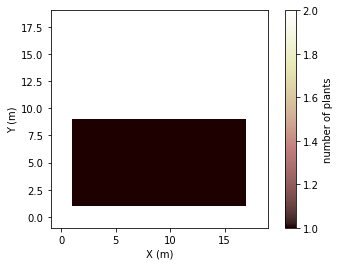

In [ ]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [ ]:
#This runs through fine for day 1 of growing season. We need to decide how to track current day
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
for i in range(run_length_d):
    #update temp attribute on grid
    pg.at_cell['air__temperature_C']=np.ones(pg.number_of_cells)*meantemp[i]
    #update solar radiation on grid
    croprun.run_one_step()
    
    if (i/7).is_integer():
        croprun.save_output()
        croprun.get_plant_output('Corn')
        write_netcdf("crop.nc",pg, format="NETCDF3_64BIT",append=True, time=(croprun.current_day-croprun.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants'])
          #if this is a save timestep, save grid object to netcdf
    #create record method in croprun that uses datarecord to save PlantGrowth object and grid at time
    #if i in savetime:
    #    croprun.record()

In [ ]:
print(vegparams)

{'Corn': {'duration_params': {'growing_season_end': 243, 'growing_season_start': 121, 'senescence_start': 228}, 'grow_params': {'glucose_requirement': [1.444, 1.513, 1.463], 'k_light_extinct': 0.51, 'light_half_sat': 100, 'p_max': 0.0372, 'plant_part_min': [0.01, 0.1, 0.5], 'respiration_coefficient': [0.015, 0.015, 0.03], 'root_to_leaf_coeffs': [0.031, 0.951, 0], 'root_to_stem_coeffs': [-0.107, 1.098, 0.0216], 'init_biomass': [0.61, 1.22]}, 'plant_factors': {'angio_gymno': 'angiosperm', 'duration': 'annual', 'growth_form': 'single_stem', 'growth_habit': 'graminoid', 'leaf_retention': 'deciduous', 'monocot_dicot': 'monocot', 'p_type': 'C4', 'shape': 'erect', 'species': 'Corn'}, 'size_params': {'max_height_stem': 1.0, 'max_n_stems': 3.0, 'max_plant_density': 34.0, 'total_cs_area_stems': 0.231}}, 'Wheat': {'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': [1.444, 1.513, 1.463], 'k_light_extinct': 0.

In [ ]:
output=croprun.get_plant_output()

In [ ]:
grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

{'filename': 'crop.nc', 'fp': <_io.BufferedReader name='crop.nc'>, 'use_mmap': True, 'mode': 'r', 'version_byte': 2, 'maskandscale': False, 'dimensions': {'nt': None, 'nj': 8, 'ni': 8, 'nv': 4}, 'variables': {'vegetation__total_biomass': <scipy.io.netcdf.netcdf_variable object at 0x00000210448BC280>, 'vegetation__n_plants': <scipy.io.netcdf.netcdf_variable object at 0x0000021043E7FC70>, 't': <scipy.io.netcdf.netcdf_variable object at 0x00000210448E0640>, 'x_bnds': <scipy.io.netcdf.netcdf_variable object at 0x00000210448E0BE0>, 'y_bnds': <scipy.io.netcdf.netcdf_variable object at 0x00000210448F6550>}, '_dims': ['nt', 'nj', 'ni', 'nv'], '_recs': 53, '_recsize': 1032, '_mm': <mmap.mmap closed=False, access=ACCESS_READ, length=59312, pos=0, offset=0>, '_mm_buf': array([67, 68, 70, ...,  0,  0,  0], dtype=int8), '_attributes': {}}


In [ ]:
timegrid=grid.variables['t']
timegrid[:]

array([ 365.,  372.,  379.,  386.,  393.,  400.,  407.,  414.,  421.,
        428.,  435.,  442.,  449.,  456.,  463.,  470.,  477.,  484.,
        491.,  498.,  505.,  512.,  519.,  526.,  533.,  540.,  547.,
        554.,  561.,  568.,  575.,  582.,  589.,  596.,  603.,  610.,
        617.,  624.,  631.,  638.,  645.,  652.,  659.,  666.,  673.,
        680.,  687.,  694.,  701.,  708.,  715.,  722.,  729.])

In [ ]:
vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

(53, 8, 8)

In [ ]:
vegbio[10,:,:]

array([[ 13.49867886,  13.4789837 ,  13.63998789,  13.29120894,
         13.67561607,  13.69393255,  13.50063545,  13.62238947],
       [ 13.37250282,  13.552327  ,  13.43526874,  13.60107176,
         13.48086257,  13.46241354,  13.69841805,  13.42553087],
       [ 14.18888117,  14.22224255,  14.25425794,  14.2326917 ,
         14.25093748,  14.23351647,  14.21922125,  14.18937874],
       [ 14.23078379,  14.25261361,  14.24323255,  14.20872459,
         14.25199174,  14.20457504,  14.22958816,  14.23902085],
       [ 27.29813966,  27.05731055,  27.31946153,  27.03026955,
         26.77319263,  27.00414214,  26.80792561,  27.16225976],
       [ 27.08132462,  27.08723601,  27.23056337,  27.16173201,
         26.94883504,  26.99198607,  27.2392358 ,  27.13321176],
       [ 28.46715778,  28.41132886,  28.49046806,  28.43924353,
         28.44040986,  28.4440849 ,  28.43666154,  28.48941601],
       [ 28.44290205,  28.46739239,  28.45040581,  28.44810313,
         28.46273815,  28.4743937

In [ ]:
output.index.unique(level=2)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64', name='item_id')

In [ ]:
output.loc[:, 'Corn',6] #timestep,species,plant number in []

,,,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass
time,vegetation__species,item_id,,,,,
0.0,Corn,6,cell,6.0,0.300420,0.342232,0.211562
1.0,Corn,6,cell,6.0,0.300420,0.342232,0.211562
29.0,Corn,6,cell,6.0,0.300420,0.342232,0.211562
57.0,Corn,6,cell,6.0,0.300420,0.342232,0.211562
85.0,Corn,6,cell,6.0,0.300420,0.342232,0.211562
...,...,...,...,...,...,...,...
702.0,Corn,6,cell,6.0,5.089477,4.929485,5.082936
709.0,Corn,6,cell,6.0,5.089477,4.929485,5.082936
716.0,Corn,6,cell,6.0,5.089477,4.929485,5.082936


In [ ]:
output.loc[141.0]

grid_element  element_id  \
vegetation__species item_id                            
Corn                0               cell         0.0   
                    1               cell         1.0   
                    2               cell         2.0   
                    3               cell         3.0   
                    4               cell         4.0   
...                                  ...         ...   
Wheat               43              cell        61.0   
                    44              cell        62.0   
                    45              cell        62.0   
                    46              cell        63.0   
                    47              cell        63.0   

                             vegetation__root_biomass  \
vegetation__species item_id                             
Corn                0                        0.918202   
                    1                        0.893683   
                    2                        1.122803   
                    3                        0.698354   
                    4                        1.183533   
...                                               ...   
Wheat               43                       0.313779   
                    44                       0.225117   
                    45                       0.224206   
                    46                       0.378719   
                    47                       0.232830   

                             vegetation__leaf_biomass  \
vegetation__species item_id                             
Corn                0                        0.991162   
                    1                        0.965981   
                    2                        1.200071   
                    3                        0.764069   
                    4                        1.261701   
...                                               ...   
Wheat               43                       0.356688   
                    44                       0.260100   
                    45                       0.259098   
                    46                       0.426559   
                    47                       0.268567   

                             vegetation__stem_biomass  
vegetation__species item_id                            
Corn                0                        0.710298  
                    1                        0.689532  
                    2                        0.885949  
                    3                        0.526523  
                    4                        0.938846  
...                                               ...  
Wheat               43                       0.221700  
                    44                       0.155240  
                    45                       0.154567  
                    46                       0.271539  
                    47                       0.160939  

[96 rows x 5 columns]

In [ ]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 0.29946009,  0.29002385,  0.38110638, ...,  4.77874983,
        4.79607886,  4.78008899])

In [ ]:
grid.close()

c:\Users\RDEL1CDP\Anaconda3\lib\site-packages\scipy\io\netcdf.py:306: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  warnings.warn((


In [ ]:
print((0/28).is_integer())

True
